In [65]:
import pandas as pd
import os
import matplotlib.pyplot as plt


timeseries_folder="../data/timeseries"
# name = "16285738312.csv" # seuil 5x5'
name = "16251238864.csv" # côte rapide pisse
name = "16235724470.csv" # VMA
name = "16285738312.csv" # seuil 5x5'
name = "16262137158.csv" # sl 2 alpes
name = "16251238864.csv" # côte rapide pisse


df = pd.read_csv(os.path.join(timeseries_folder, name))

df.head()


,timestamp,hr,paceKmh,elevationM,cadence,lat,lon
0,2025-10-25T10:32:13+00:00,84,0.0000,1305.8,0,45.035879,6.144205
1,2025-10-25T10:32:14+00:00,85,5.0400,1305.8,0,45.035869,6.144191
2,2025-10-25T10:32:15+00:00,85,5.2200,1305.6,66,45.035857,6.144185
3,2025-10-25T10:32:16+00:00,86,5.8788,1305.6,66,45.035832,6.144165
4,2025-10-25T10:32:17+00:00,85,7.2000,1305.4,66,45.035805,6.144151


In [66]:
import sys
sys.path.append('..')

from services.speed_profile_service import SpeedProfileService
from utils.config import Config

sp = SpeedProfileService(config=None)

df=sp.preprocess_timeseries(df)

print(df.head())


                  timestamp  hr  paceKmh  elevationM  cadence        lat  \
0 2025-10-25 10:32:14+00:00  85   5.0400      1305.8        0  45.035869   
1 2025-10-25 10:32:15+00:00  85   5.2200      1305.6       66  45.035857   
2 2025-10-25 10:32:16+00:00  86   5.8788      1305.6       66  45.035832   
3 2025-10-25 10:32:17+00:00  85   7.2000      1305.4       66  45.035805   
4 2025-10-25 10:32:18+00:00  85   8.5680      1305.4        0  45.035773   

        lon   lat_ma_5  lon_ma_5  elevationM_ma_5  ...      time  \
0  6.144191  45.035859  6.144186          1305.70  ...  10:32:14   
1  6.144185  45.035848  6.144179          1305.64  ...  10:32:15   
2  6.144165  45.035827  6.144167          1305.56  ...  10:32:16   
3  6.144151  45.035801  6.144154          1305.48  ...  10:32:17   
4  6.144143  45.035772  6.144139          1305.40  ...  10:32:18   

         duration  cumulated_duration  duration_seconds  \
0 0 days 00:00:00     0 days 00:00:00          1.138485   
1 0 days 00:00:0

In [67]:
import numpy as np
# Create histogram data
def create_histogram(df, bins=30,col="grade"):
    """
    Create a histogram table for grade values and define columns to drop.
    
    Parameters:
    df (DataFrame): Input dataframe containing 'grade' column
    bins (int): Number of bins for the histogram
    
    Returns:
    tuple: (hist_table, col_to_drop) where hist_table is the histogram DataFrame
           and col_to_drop is the list of columns to remove
    """
    counts, bin_edges = np.histogram(df[col], bins=bins)
    
    # Create table with bin ranges and frequencies
    hist_table = pd.DataFrame({
        'Bin Range': [f"{bin_edges[i]:.3f} - {bin_edges[i+1]:.3f}" for i in range(len(bin_edges)-1)],
        'Frequency': counts
    })
    
    
    return hist_table

# Display the table
hist_table = create_histogram(df)
print("Histogram of Grade Values (Table Format):")
print(hist_table.to_string(index=False))

col_to_drop = ["lat","lon","duration","cumulated_duration","time"]

df.drop(columns=col_to_drop, inplace=True)

# Get rows with absolute grade greater than 100
outlier_rows = df[abs(df['grade']) > 2]
print("Rows with |grade| > 100:")
print(outlier_rows)




Histogram of Grade Values (Table Format):
       Bin Range  Frequency
-10.201 - -9.321          1
 -9.321 - -8.442          0
 -8.442 - -7.563          0
 -7.563 - -6.683          0
 -6.683 - -5.804          0
 -5.804 - -4.925          0
 -4.925 - -4.045          1
 -4.045 - -3.166          3
 -3.166 - -2.287          4
 -2.287 - -1.408          3
 -1.408 - -0.528        139
  -0.528 - 0.351       6441
   0.351 - 1.230        487
   1.230 - 2.110          6
   2.110 - 2.989          2
   2.989 - 3.868          0
   3.868 - 4.747          1
   4.747 - 5.627          0
   5.627 - 6.506          0
   6.506 - 7.385          0
   7.385 - 8.265          0
   8.265 - 9.144          1
  9.144 - 10.023          0
 10.023 - 10.903          0
 10.903 - 11.782          1
 11.782 - 12.661          1
 12.661 - 13.540          0
 13.540 - 14.420          0
 14.420 - 15.299          0
 15.299 - 16.178          1
Rows with |grade| > 100:
                     timestamp   hr  paceKmh  elevationM  cadence

In [68]:
df=sp.moving_average(df, window_size=10, col="grade")
print(df.head())
# df.rename(columns={"grade_ma_10":"grade"}, inplace=True)
hist_table = create_histogram(df,col="grade_ma_10")
print("Histogram of Grade Values (Table Format):")
print(hist_table.to_string(index=False))


                  timestamp  hr  paceKmh  elevationM  cadence   lat_ma_5  \
0 2025-10-25 10:32:14+00:00  85   5.0400      1305.8        0  45.035859   
1 2025-10-25 10:32:15+00:00  85   5.2200      1305.6       66  45.035848   
2 2025-10-25 10:32:16+00:00  86   5.8788      1305.6       66  45.035827   
3 2025-10-25 10:32:17+00:00  85   7.2000      1305.4       66  45.035801   
4 2025-10-25 10:32:18+00:00  85   8.5680      1305.4        0  45.035772   

   lon_ma_5  elevationM_ma_5  distance  elevation_difference  ...  \
0  6.144186          1305.70  0.001156                  0.00  ...   
1  6.144179          1305.64  0.001329                 -0.06  ...   
2  6.144167          1305.56  0.002551                 -0.08  ...   
3  6.144154          1305.48  0.003051                 -0.08  ...   
4  6.144139          1305.40  0.003459                 -0.08  ...   

   elevation_gain  elevation_loss  duration_seconds  \
0             0.0            0.00          1.138485   
1             0.0 

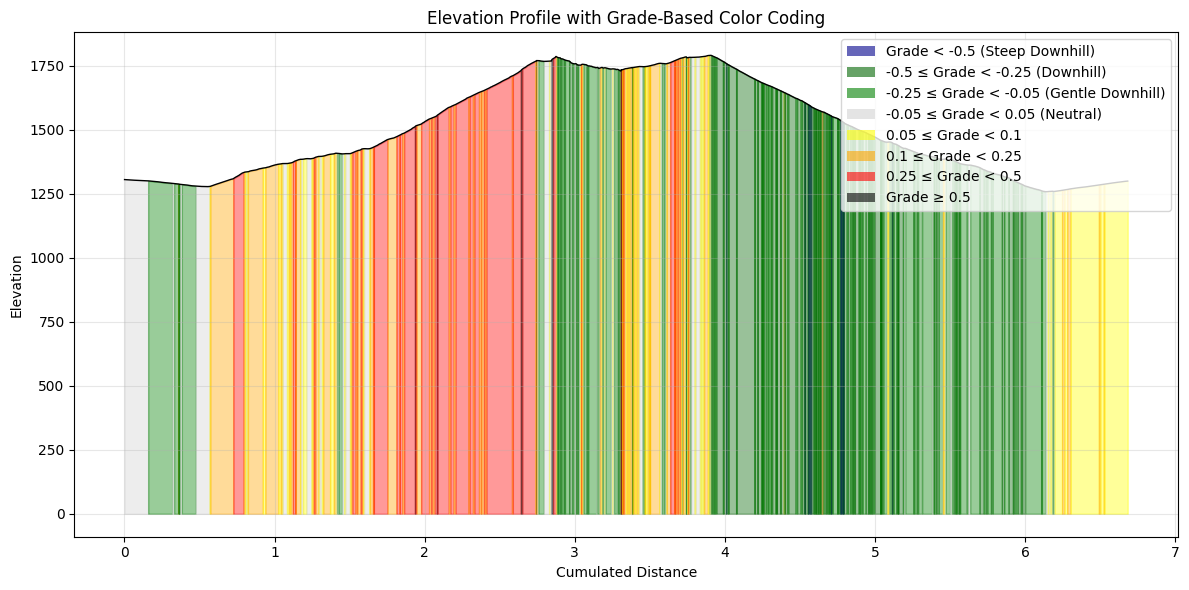

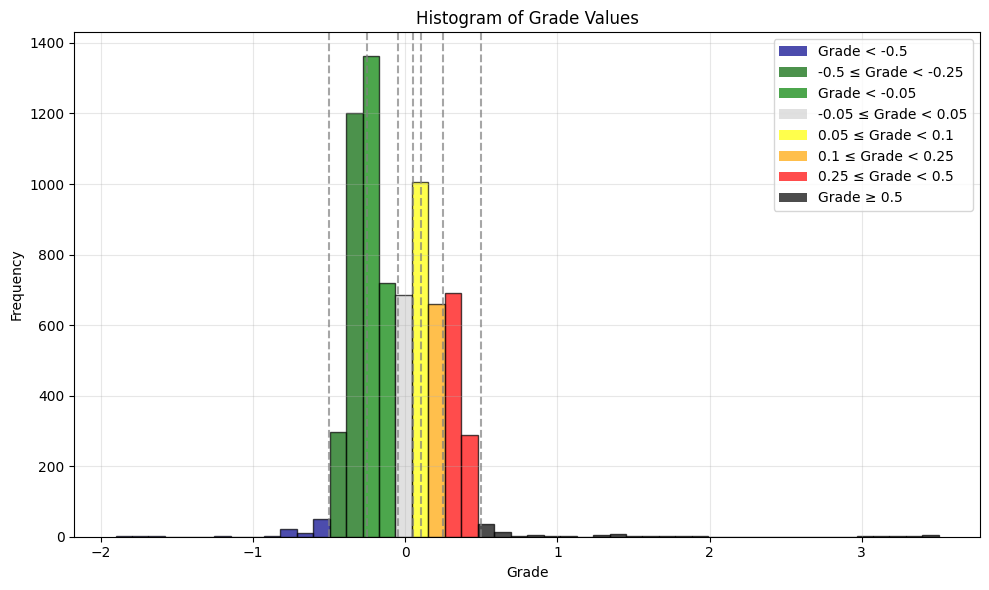

In [69]:
# Define color palette configuration
COLOR_PALETTE = {
    'grade_lt_neg_0_5': 'darkblue',    # Grade < -0.5
    'grade_lt_neg_0_25': 'darkgreen',  # -0.5 ≤ Grade < -0.25
    'grade_lt_neg_0_05': 'green',      # -0.25 ≤ Grade < -0.05
    'grade_neutral': 'lightgray',      # -0.05 ≤ Grade < 0.05
    'grade_lt_0_1': 'yellow',          # 0.05 ≤ Grade < 0.1
    'grade_lt_0_25': 'orange',         # 0.1 ≤ Grade < 0.25
    'grade_lt_0_5': 'red',             # 0.25 ≤ Grade < 0.5
    'grade_ge_0_5': 'black'            # Grade ≥ 0.5
}

def plot_elevation_with_gradient(df, elevation_col='elevationM', cumulated_dist_col='cumulated_distance', grade_col='grade'):
    """
    Plot elevation over cumulated distance with color-coded fill based on grade values.
    
    Parameters:
    df (DataFrame): Input dataframe containing cumulated distance and grade columns
    cumulated_dist_col (str): Name of the cumulated distance column
    grade_col (str): Name of the grade column
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the elevation profile
    ax.plot(df[cumulated_dist_col], df[elevation_col], 'k-', linewidth=1, label='Elevation Profile')
    
    # Group consecutive segments with the same color category
    x = df[cumulated_dist_col].values
    y = df[elevation_col].values
    grades = df[grade_col].values
    
    # Create color mapping function using config palette
    def get_color(grade_val):
        if grade_val < -0.5:
            return COLOR_PALETTE['grade_lt_neg_0_5']
        elif -0.5 <= grade_val < -0.25:
            return COLOR_PALETTE['grade_lt_neg_0_25']
        elif -0.25 <= grade_val < -0.05:
            return COLOR_PALETTE['grade_lt_neg_0_05']
        elif -0.05 <= grade_val < 0.05:
            return COLOR_PALETTE['grade_neutral']
        elif 0.05 <= grade_val < 0.1:
            return COLOR_PALETTE['grade_lt_0_1']
        elif 0.1 <= grade_val < 0.25:
            return COLOR_PALETTE['grade_lt_0_25']
        elif 0.25 <= grade_val < 0.5:
            return COLOR_PALETTE['grade_lt_0_5']
        else:
            return COLOR_PALETTE['grade_ge_0_5']
    
    # Find segments with the same color
    current_color = get_color(grades[0])
    segment_start = 0
    
    for i in range(1, len(grades)):
        color = get_color(grades[i])
        if color != current_color:
            # Fill the entire segment with the same color
            ax.fill_between(x[segment_start:i+1], y[segment_start:i+1], 0, 
                           color=current_color, alpha=0.4)
            segment_start = i
            current_color = color
    
    # Fill the last segment
    ax.fill_between(x[segment_start:], y[segment_start:], 0, 
                   color=current_color, alpha=0.4)
    
    ax.set_xlabel('Cumulated Distance')
    ax.set_ylabel('Elevation')
    ax.set_title('Elevation Profile with Grade-Based Color Coding')
    ax.grid(True, alpha=0.3)
    
    # Create custom legend for grade colors using config palette
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLOR_PALETTE['grade_lt_neg_0_5'], alpha=0.6, label='Grade < -0.5 (Steep Downhill)'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_neg_0_25'], alpha=0.6, label='-0.5 ≤ Grade < -0.25 (Downhill)'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_neg_0_05'], alpha=0.6, label='-0.25 ≤ Grade < -0.05 (Gentle Downhill)'),
        Patch(facecolor=COLOR_PALETTE['grade_neutral'], alpha=0.6, label='-0.05 ≤ Grade < 0.05 (Neutral)'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_0_1'], alpha=0.6, label='0.05 ≤ Grade < 0.1'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_0_25'], alpha=0.6, label='0.1 ≤ Grade < 0.25'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_0_5'], alpha=0.6, label='0.25 ≤ Grade < 0.5'),
        Patch(facecolor=COLOR_PALETTE['grade_ge_0_5'], alpha=0.6, label='Grade ≥ 0.5')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

def plot_grade_histogram(df, grade_col='grade_ma_10'):
    """
    Plot a histogram of grade values with color coding matching the elevation profile
    
    Parameters:
    df (DataFrame): DataFrame containing grade data
    grade_col (str): Column name for grade values
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get grade values
    grades = df[grade_col].dropna()
    
    # Define bin edges
    bin_edges = [-np.inf, -0.5, -0.25, -0.05, 0.05, 0.1, 0.25, 0.5, np.inf]
    
    # Plot histogram with color coding
    n, bins, patches = ax.hist(grades, bins=50, alpha=0.7, edgecolor='black')
    
    # Color each bar based on its bin center using config palette
    for i, patch in enumerate(patches):
        # Calculate bin center
        bin_center = (bins[i] + bins[i+1]) / 2
        
        # Determine color based on bin center using config palette
        if bin_center < -0.5:
            color = COLOR_PALETTE['grade_lt_neg_0_5']
        elif -0.5 <= bin_center < -0.25:
            color = COLOR_PALETTE['grade_lt_neg_0_25']
        elif -0.25 <= bin_center < -0.05:
            color = COLOR_PALETTE['grade_lt_neg_0_05']
        elif -0.05 <= bin_center < 0.05:
            color = COLOR_PALETTE['grade_neutral']
        elif 0.05 <= bin_center < 0.1:
            color = COLOR_PALETTE['grade_lt_0_1']
        elif 0.1 <= bin_center < 0.25:
            color = COLOR_PALETTE['grade_lt_0_25']
        elif 0.25 <= bin_center < 0.5:
            color = COLOR_PALETTE['grade_lt_0_5']
        else:
            color = COLOR_PALETTE['grade_ge_0_5']
        
        patch.set_facecolor(color)
    
    ax.set_xlabel('Grade')
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of Grade Values')
    ax.grid(True, alpha=0.3)
    
    # Add vertical lines at grade boundaries
    for boundary in [-0.5, -0.25, -0.05, 0.05, 0.1, 0.25, 0.5]:
        ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.7)
    
    # Create custom legend using config palette
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=COLOR_PALETTE['grade_lt_neg_0_5'], alpha=0.7, label='Grade < -0.5'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_neg_0_25'], alpha=0.7, label='-0.5 ≤ Grade < -0.25'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_neg_0_05'], alpha=0.7, label='Grade < -0.05'),
        Patch(facecolor=COLOR_PALETTE['grade_neutral'], alpha=0.7, label='-0.05 ≤ Grade < 0.05'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_0_1'], alpha=0.7, label='0.05 ≤ Grade < 0.1'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_0_25'], alpha=0.7, label='0.1 ≤ Grade < 0.25'),
        Patch(facecolor=COLOR_PALETTE['grade_lt_0_5'], alpha=0.7, label='0.25 ≤ Grade < 0.5'),
        Patch(facecolor=COLOR_PALETTE['grade_ge_0_5'], alpha=0.7, label='Grade ≥ 0.5')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage (commented out):
plot_elevation_with_gradient(df, elevation_col='elevationM_ma_5', cumulated_dist_col='cumulated_distance', grade_col='grade_ma_10')

# Example usage (commented out):
plot_grade_histogram(df, grade_col='grade_ma_10')


In [70]:
# ============================================================================
# Speed Equivalent Calculation based on Minetti et al. (2002)
# ============================================================================
# 
# Minetti et al. (2002) developed polynomial equations to model the energy cost
# of walking and running at different grades (slopes). The energy cost is expressed
# as a function of grade (i), where i is a decimal (e.g., 0.1 = 10% grade).
#
# Energy Cost Formulas:
# - Walking:  Cw(i) = 280.5i^5 - 58.7i^4 - 76.8i^3 + 51.9i^2 + 19.6i + 2.5
# - Running:  Cr(i) = 155.4i^5 - 30.4i^4 - 43.3i^3 + 46.3i^2 + 19.5i + 3.6
#
# The equivalent speed (speed_eq) represents the speed on flat ground that would
# require the same energy expenditure as the actual speed on the given grade.
#
# Calculation: speed_eq = speed * (C(grade) / C(0))
# - For walking: C(0) = 2.5 (the constant term)
# - For running: C(0) = 3.6 (the constant term)
#
# Classification rule: speed <= 6 km/h → walking, otherwise → running
# ============================================================================

import numpy as np

def energy_cost_walking(grade):
    """
    Calculate energy cost of walking at a given grade.
    
    Parameters:
    grade (float): Grade as decimal (e.g., 0.1 for 10% grade)
    
    Returns:
    float: Energy cost per unit distance
    """
    if grade >= 0.5:
        grade = 0.5
    elif grade <= -0.5:
        grade = -0.5

    return (280.5 * grade**5 - 
            58.7 * grade**4 - 
            76.8 * grade**3 + 
            51.9 * grade**2 + 
            19.6 * grade + 
            2.5)

def energy_cost_running(grade):
    """
    Calculate energy cost of running at a given grade.
    
    Parameters:
    grade (float): Grade as decimal (e.g., 0.1 for 10% grade)
    
    Returns:
    float: Energy cost per unit distance
    """
    if grade >= 0.5:
        grade = 0.5
    elif grade <= -0.5:
        grade = -0.5

    return (155.4 * grade**5 - 
            30.4 * grade**4 - 
            43.3 * grade**3 + 
            46.3 * grade**2 + 
            19.5 * grade + 
            3.6)

# Constants for energy cost on flat ground (grade = 0)
ENERGY_COST_WALKING_FLAT = 2.5  # Cw(0)
ENERGY_COST_RUNNING_FLAT = 3.6  # Cr(0)

# Threshold for walking vs running classification (km/h)
WALKING_THRESHOLD = 6.0

def calculate_speed_eq(row):
    """
    Calculate equivalent speed on flat ground based on Minetti energy cost model.
    
    Parameters:
    row (Series): DataFrame row containing 'speed_km_h' and 'grade_ma_10'
    
    Returns:
    float: Equivalent speed in km/h
    """
    speed = row['speed_km_h']
    grade = row['grade_ma_10']
    
    # Handle NaN values
    if pd.isna(speed) or pd.isna(grade):
        return np.nan
    
    # Classify as walking or running
    if speed <= WALKING_THRESHOLD:
        # Walking
        cost_at_grade = energy_cost_walking(grade)
        if cost_at_grade <= 0:
            print(f"cost_at_grade < 0: {cost_at_grade} for grade {grade}")
        cost_flat = ENERGY_COST_WALKING_FLAT
    else:
        # Running
        cost_at_grade = energy_cost_running(grade)
        if cost_at_grade <= 0:
            print(f"cost_at_grade < 0: {cost_at_grade} ")
        cost_flat = ENERGY_COST_RUNNING_FLAT
    
    # Calculate equivalent speed: speed_eq = speed * (C(grade) / C(0))
    # This represents the speed on flat ground that would require the same energy
    speed_eq = max(0, speed * (cost_at_grade / cost_flat))
    
    return speed_eq

# Calculate speed_eq for each timestamp
print("Calculating speed_eq using Minetti et al. (2002) energy cost formulas...")
df['speed_eq'] = df.apply(calculate_speed_eq, axis=1)
df=sp.moving_average(df, window_size=30, col="speed_eq")
df=df.drop(columns=["speed_eq"])
df=df.rename(columns={"speed_eq_ma_30":"speed_eq"})
print(df.keys())

# Display statistics
print("\nSpeed Statistics:")
print(f"Original speed (km/h):")
print(f"  Mean: {df['speed_km_h'].mean():.2f}")
print(f"  Median: {df['speed_km_h'].median():.2f}")
print(f"  Std: {df['speed_km_h'].std():.2f}")
print(f"  Min: {df['speed_km_h'].min():.2f}")
print(f"  Max: {df['speed_km_h'].max():.2f}")

print(f"\nEquivalent speed (km/h):")
print(f"  Mean: {df['speed_eq'].mean():.2f}")
print(f"  Median: {df['speed_eq'].median():.2f}")
print(f"  Std: {df['speed_eq'].std():.2f}")
print(f"  Min: {df['speed_eq'].min():.2f}")
print(f"  Max: {df['speed_eq'].max():.2f}")

# Calculate walking vs running counts
walking_count = (df['speed_km_h'] <= WALKING_THRESHOLD).sum()
running_count = (df['speed_km_h'] > WALKING_THRESHOLD).sum()
print(f"\nClassification:")
print(f"  Walking (speed <= {WALKING_THRESHOLD} km/h): {walking_count} ({walking_count/len(df)*100:.1f}%)")
print(f"  Running (speed > {WALKING_THRESHOLD} km/h): {running_count} ({running_count/len(df)*100:.1f}%)")

# Display sample of results
print("\nSample of calculated speed_eq:")
sample_cols = ['speed_km_h', 'grade_ma_10', 'speed_eq']
print(df[sample_cols].head(10).to_string(index=False))


Calculating speed_eq using Minetti et al. (2002) energy cost formulas...
Index(['timestamp', 'hr', 'paceKmh', 'elevationM', 'cadence', 'lat_ma_5',
       'lon_ma_5', 'elevationM_ma_5', 'distance', 'elevation_difference',
       'elevation_cumulated', 'elevation_gain', 'elevation_loss',
       'duration_seconds', 'cumulated_duration_seconds', 'cumulated_distance',
       'distance_ma_10', 'speed_m_s', 'speed_km_h', 'grade', 'grade_ma_10',
       'speed_eq'],
      dtype='object')

Speed Statistics:
Original speed (km/h):
  Mean: 3.39
  Median: 3.16
  Std: 2.09
  Min: 0.00
  Max: 14.32

Equivalent speed (km/h):
  Mean: 6.42
  Median: 2.78
  Std: 6.17
  Min: 0.22
  Max: 23.47

Classification:
  Walking (speed <= 6.0 km/h): 6634 (93.5%)
  Running (speed > 6.0 km/h): 458 (6.5%)

Sample of calculated speed_eq:
 speed_km_h  grade_ma_10  speed_eq
   3.656660    -0.022561  8.257099
   4.785177    -0.023600  8.265075
   9.182762    -0.024094  8.302395
  10.982088    -0.025897  8.366109
  12.4539

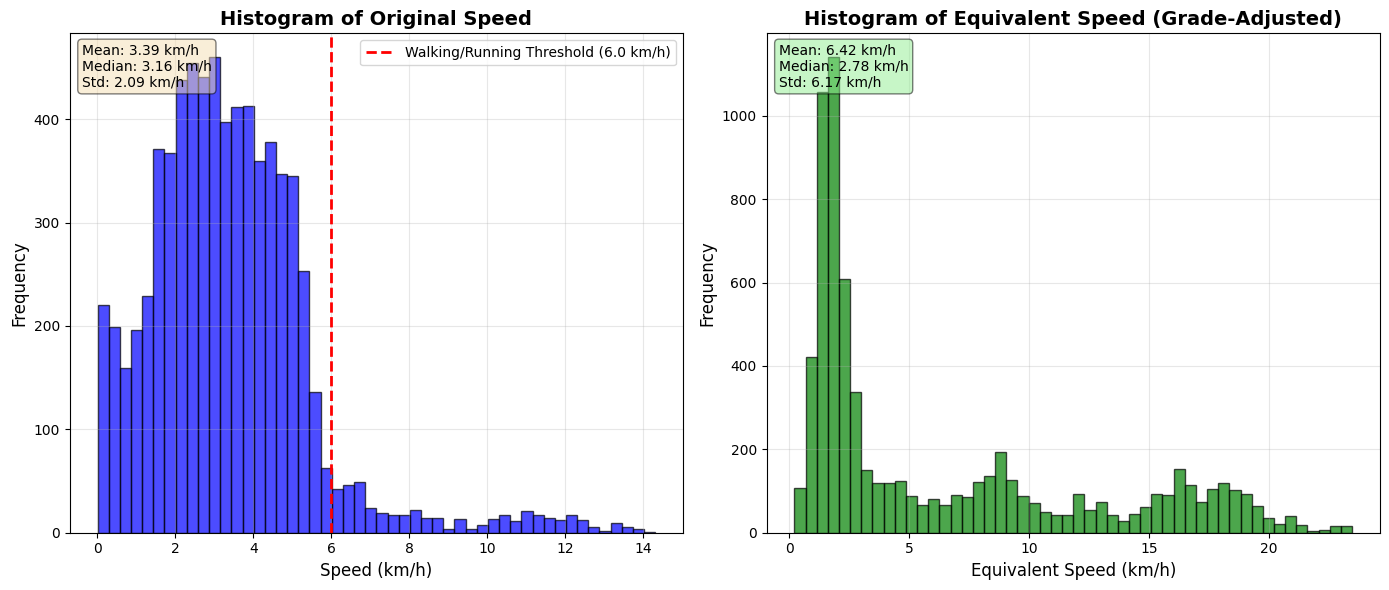

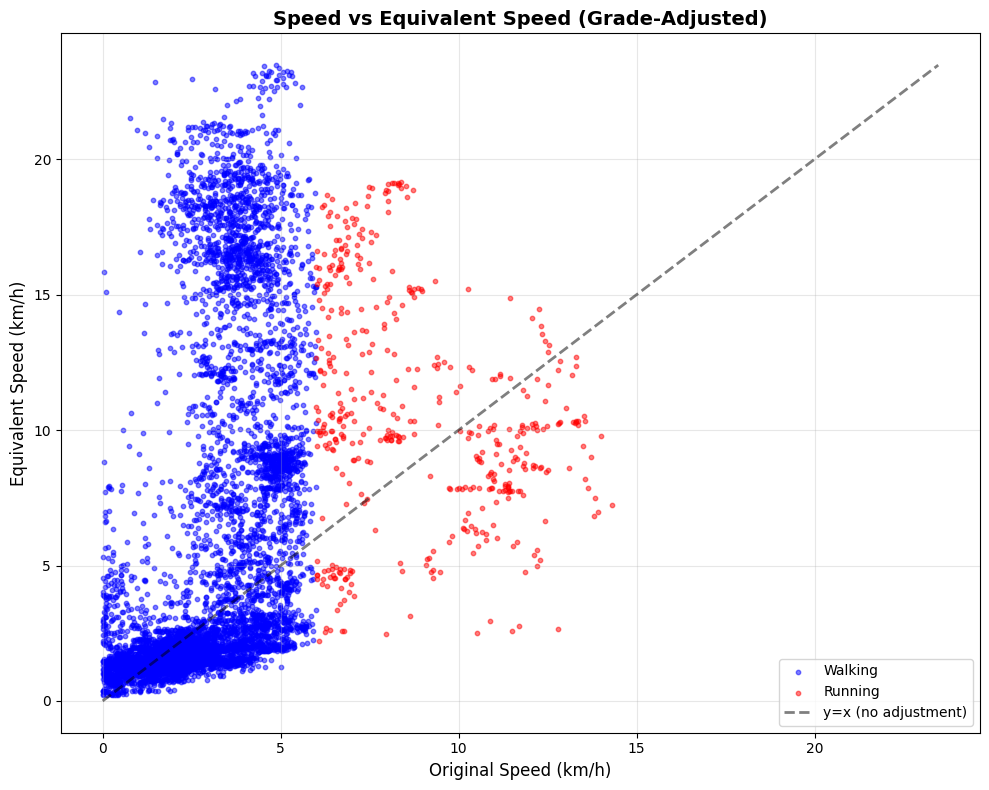


SUMMARY: Grade Adjustment Impact

Difference (speed_eq - speed):
  Mean: 3.03 km/h
  Median: 0.37 km/h
  Std: 5.65 km/h
  Points above diagonal (uphill harder): 4093 (57.7%)
  Points below diagonal (downhill easier): 2999 (42.3%)

Equivalent Speed by Grade Category:
  Steep Downhill (<-30%):
    Avg speed: 1.81 km/h → 1.83 km/h (diff: +0.02 km/h)
    Count: 1326 (18.7%)
  Downhill (-30% to -10%):
    Avg speed: 2.81 km/h → 1.84 km/h (diff: -0.97 km/h)
    Count: 2110 (29.8%)
  Downhill (-10% to -5%):
    Avg speed: 5.25 km/h → 3.90 km/h (diff: -1.35 km/h)
    Count: 378 (5.3%)
  Flat (-5% to 5%):
    Avg speed: 5.11 km/h → 5.45 km/h (diff: +0.35 km/h)
    Count: 589 (8.3%)
  Uphill (5% to 10%):
    Avg speed: 4.65 km/h → 7.92 km/h (diff: +3.27 km/h)
    Count: 596 (8.4%)
  Medium Uphill (10% to 30%):
    Avg speed: 4.16 km/h → 12.38 km/h (diff: +8.22 km/h)
    Count: 1313 (18.5%)
  Steep Uphill (>30%):
    Avg speed: 3.20 km/h → 17.36 km/h (diff: +14.16 km/h)
    Count: 780 (11.0%)


In [71]:
# ============================================================================
# Plot Histograms of Speed and Speed Equivalent
# ============================================================================

import matplotlib.pyplot as plt

# Filter out NaN values for plotting
df_plot = df[['speed_km_h', 'speed_eq']].dropna()

if len(df_plot) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Histogram of original speed
    ax1 = axes[0]
    n_bins = 50
    ax1.hist(df_plot['speed_km_h'], bins=n_bins, color='blue', alpha=0.7, edgecolor='black')
    ax1.axvline(WALKING_THRESHOLD, color='red', linestyle='--', linewidth=2, 
                label=f'Walking/Running Threshold ({WALKING_THRESHOLD} km/h)')
    ax1.set_xlabel('Speed (km/h)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Histogram of Original Speed', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Add statistics text box
    stats_text = f'Mean: {df_plot["speed_km_h"].mean():.2f} km/h\n'
    stats_text += f'Median: {df_plot["speed_km_h"].median():.2f} km/h\n'
    stats_text += f'Std: {df_plot["speed_km_h"].std():.2f} km/h'
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Histogram of equivalent speed
    ax2 = axes[1]
    ax2.hist(df_plot['speed_eq'], bins=n_bins, color='green', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Equivalent Speed (km/h)', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Histogram of Equivalent Speed (Grade-Adjusted)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add statistics text box
    stats_text_eq = f'Mean: {df_plot["speed_eq"].mean():.2f} km/h\n'
    stats_text_eq += f'Median: {df_plot["speed_eq"].median():.2f} km/h\n'
    stats_text_eq += f'Std: {df_plot["speed_eq"].std():.2f} km/h'
    ax2.text(0.02, 0.98, stats_text_eq, transform=ax2.transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # Additional comparison plot: Speed vs Speed_eq scatter
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Color code by walking vs running
    walking_mask = df_plot['speed_km_h'] <= WALKING_THRESHOLD
    running_mask = ~walking_mask
    
    ax.scatter(df_plot.loc[walking_mask, 'speed_km_h'], 
               df_plot.loc[walking_mask, 'speed_eq'], 
               alpha=0.5, color='blue', label='Walking', s=10)
    ax.scatter(df_plot.loc[running_mask, 'speed_km_h'], 
               df_plot.loc[running_mask, 'speed_eq'], 
               alpha=0.5, color='red', label='Running', s=10)
    
    # Add diagonal line (y=x) for reference
    min_speed = min(df_plot['speed_km_h'].min(), df_plot['speed_eq'].min())
    max_speed = max(df_plot['speed_km_h'].max(), df_plot['speed_eq'].max())
    ax.plot([min_speed, max_speed], [min_speed, max_speed], 
            'k--', linewidth=2, alpha=0.5, label='y=x (no adjustment)')
    
    ax.set_xlabel('Original Speed (km/h)', fontsize=12)
    ax.set_ylabel('Equivalent Speed (km/h)', fontsize=12)
    ax.set_title('Speed vs Equivalent Speed (Grade-Adjusted)', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("SUMMARY: Grade Adjustment Impact")
    print("="*70)
    
    speed_diff = df_plot['speed_eq'] - df_plot['speed_km_h']
    print(f"\nDifference (speed_eq - speed):")
    print(f"  Mean: {speed_diff.mean():.2f} km/h")
    print(f"  Median: {speed_diff.median():.2f} km/h")
    print(f"  Std: {speed_diff.std():.2f} km/h")
    print(f"  Points above diagonal (uphill harder): {(speed_diff > 0).sum()} ({(speed_diff > 0).sum()/len(speed_diff)*100:.1f}%)")
    print(f"  Points below diagonal (downhill easier): {(speed_diff < 0).sum()} ({(speed_diff < 0).sum()/len(speed_diff)*100:.1f}%)")
    
    # Analyze by grade category
    print(f"\nEquivalent Speed by Grade Category:")
    grade_categories = pd.cut(df['grade_ma_10'].dropna(), 
                               bins=[-np.inf,-0.3, -0.1, -0.05, 0.05, 0.1, 0.30, np.inf],
                               labels=['Steep Downhill (<-30%)', 'Downhill (-30% to -10%)', 'Downhill (-10% to -5%)',
                                      'Flat (-5% to 5%)', 'Uphill (5% to 10%)','Medium Uphill (10% to 30%)', 'Steep Uphill (>30%)'])
    
    df_grade_analysis = df[['speed_km_h', 'speed_eq', 'grade_ma_10']].dropna().copy()
    df_grade_analysis['grade_category'] = grade_categories
    
    for category in df_grade_analysis['grade_category'].cat.categories:
        cat_data = df_grade_analysis[df_grade_analysis['grade_category'] == category]
        if len(cat_data) > 0:
            avg_speed = cat_data['speed_km_h'].mean()
            avg_speed_eq = cat_data['speed_eq'].mean()
            diff = avg_speed_eq - avg_speed
            print(f"  {category}:")
            print(f"    Avg speed: {avg_speed:.2f} km/h → {avg_speed_eq:.2f} km/h (diff: {diff:+.2f} km/h)")
            print(f"    Count: {len(cat_data)} ({len(cat_data)/len(df_grade_analysis)*100:.1f}%)")
    
else:
    print("No valid data available for plotting. Check that 'speed_km_h' and 'grade_ma_10' columns exist.")


In [72]:
print(df.head())

# Compute equivalent distance using equivalent speed and duration
df['dist_eq'] = df['speed_eq'] * (df['duration_seconds'] / 3600)  # Convert seconds to hours for km/h to km conversion
df['cumulated_distance_eq'] = df['dist_eq'].cumsum()
# Add equivalent distance to the plotting dataframe if it exists
# if 'df_plot' in locals() and not df_plot.empty:
#     df_plot['dist_eq'] = df_plot['speed_eq'] * (df_plot['duration_seconds'] / 3600)
    
print(df[['elevation_gain','cumulated_distance','cumulated_distance_eq']].tail())



                  timestamp  hr  paceKmh  elevationM  cadence   lat_ma_5  \
0 2025-10-25 10:32:14+00:00  85   5.0400      1305.8        0  45.035859   
1 2025-10-25 10:32:15+00:00  85   5.2200      1305.6       66  45.035848   
2 2025-10-25 10:32:16+00:00  86   5.8788      1305.6       66  45.035827   
3 2025-10-25 10:32:17+00:00  85   7.2000      1305.4       66  45.035801   
4 2025-10-25 10:32:18+00:00  85   8.5680      1305.4        0  45.035772   

   lon_ma_5  elevationM_ma_5  distance  elevation_difference  ...  \
0  6.144186          1305.70  0.001156                  0.00  ...   
1  6.144179          1305.64  0.001329                 -0.06  ...   
2  6.144167          1305.56  0.002551                 -0.08  ...   
3  6.144154          1305.48  0.003051                 -0.08  ...   
4  6.144139          1305.40  0.003459                 -0.08  ...   

   elevation_loss  duration_seconds  cumulated_duration_seconds  \
0            0.00          1.138485                         0

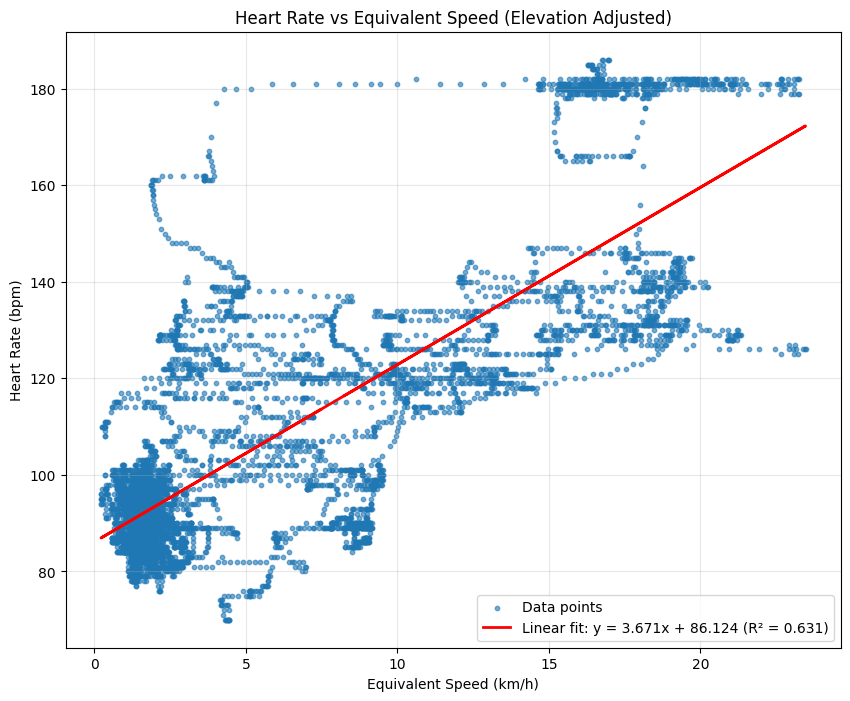

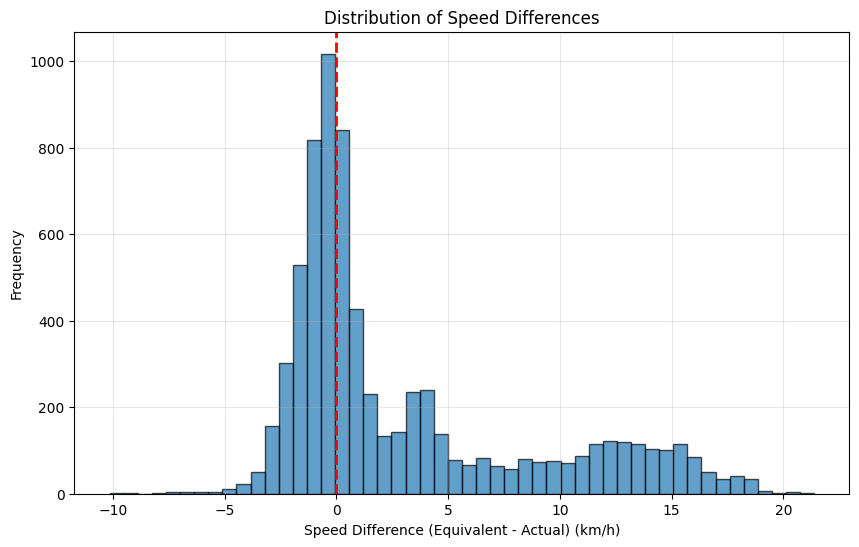

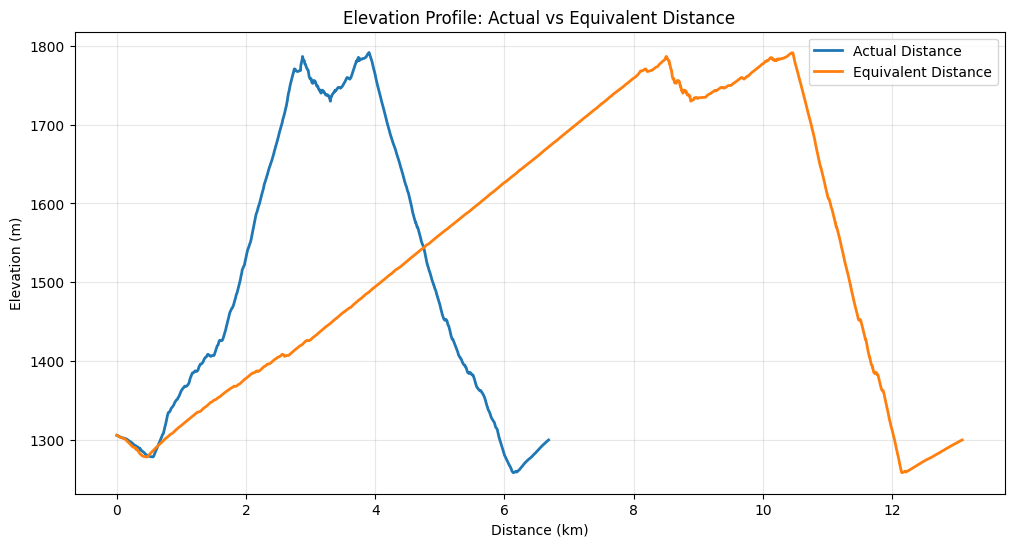

In [80]:
# Plot heart rate vs equivalent speed point cloud with linear regression
import matplotlib.pyplot as plt
from scipy import stats

plt.figure(figsize=(10, 8))
plt.scatter( df['speed_eq'],df['hr'], alpha=0.6, s=10, label='Data points')

# Calculate linear regression
if 'hr' in df.columns and 'speed_eq' in df.columns:
    valid_data = df[['speed_eq','hr']].dropna()
    if len(valid_data) > 1:
        y = valid_data['hr']
        x = valid_data['speed_eq']
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        plt.plot(x, intercept + slope*x, 'r-', linewidth=2, 
                label=f'Linear fit: y = {slope:.3f}x + {intercept:.3f} (R² = {r_value**2:.3f})')
        
plt.xlabel('Equivalent Speed (km/h)')
plt.ylabel('Heart Rate (bpm)')
plt.title('Heart Rate vs Equivalent Speed (Elevation Adjusted)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot speed difference distribution
plt.figure(figsize=(10, 6))
speed_diff = df['speed_eq'] - df['speed_km_h']
plt.hist(speed_diff.dropna(), bins=50, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Speed Difference (Equivalent - Actual) (km/h)')
plt.ylabel('Frequency')
plt.title('Distribution of Speed Differences')
plt.grid(True, alpha=0.3)
plt.show()

# Plot cumulative distance comparison
plt.figure(figsize=(12, 6))
plt.plot(df['cumulated_distance'], df['elevationM_ma_5'], label='Actual Distance', linewidth=2)
plt.plot(df['cumulated_distance_eq'], df['elevationM_ma_5'], label='Equivalent Distance', linewidth=2)
plt.xlabel('Distance (km)')
plt.ylabel('Elevation (m)')
plt.title('Elevation Profile: Actual vs Equivalent Distance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
